# Preparing the dataset for hippocampus segmentation

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os
from collections import Counter

from pylab import rcParams
rcParams['figure.figsize'] = 12,8

import random
random.seed(42)

It will help your understanding of the data a lot if you were able to use a tool that allows you to view NIFTI volumes, like [3D Slicer](https://www.slicer.org/).

In [2]:
def show_images(file):
    image_data = images[file].get_fdata()
    label_data = labels[file].get_fdata()
    
    fig = plt.figure()
    fig.suptitle(f"image={file}", y=0.93)

    fig.add_subplot(2, 3, 1)
    plt.imshow(image_data[np.random.randint(0, min(image_data.shape)), :, :].T, cmap="gray")
    plt.title('Coronal')

    fig.add_subplot(2, 3, 2)
    plt.imshow(image_data[:, np.random.randint(0, min(image_data.shape)), :].T, cmap="gray")
    plt.title('Sagittal')

    fig.add_subplot(2, 3, 3)
    plt.imshow(image_data[:, :, np.random.randint(0, min(image_data.shape))].T, cmap="gray")
    plt.title('Axial')

    fig.add_subplot(2, 3, 4)
    plt.imshow(label_data[np.random.randint(0, min(label_data.shape)), :, :].T, cmap="gray")

    fig.add_subplot(2, 3, 5)
    plt.imshow(label_data[:, np.random.randint(0, min(label_data.shape)), :].T, cmap="gray")

    fig.add_subplot(2, 3, 6)
    plt.imshow(label_data[:, :, np.random.randint(0, min(label_data.shape))].T, cmap="gray")
        
    plt.show()

In [3]:
def show_volume_rendering(file):
    image_data = images[file].get_fdata()
    
    row = 4
    col = 3
    
    fig = plt.figure(figsize=(12,16))
    fig.suptitle(f"image={file}", y=0.93)

    fig.add_subplot(row, col, 1)
    plt.imshow(image_data[np.random.randint(0, min(image_data.shape)), :, :].T, cmap="gray")
    plt.title('Coronal')

    fig.add_subplot(row, col, 2)
    plt.imshow(image_data[:, np.random.randint(0, min(image_data.shape)), :].T, cmap="gray")
    plt.title('Sagittal')

    fig.add_subplot(row, col, 3)
    plt.imshow(image_data[:, :, np.random.randint(0, min(image_data.shape))].T, cmap="gray")
    plt.title('Axial')
        
    # sum
    fig.add_subplot(row, col, 4)
    plt.imshow(image_data.sum(axis=0).T, cmap="gray")
    plt.title('Sum')

    fig.add_subplot(row, col, 5)
    plt.imshow(image_data.sum(axis=1).T, cmap="gray")
    plt.title('Sum')

    fig.add_subplot(row, col, 6)
    plt.imshow(image_data.sum(axis=2).T, cmap="gray")
    plt.title('Sum')
    
    # max
    fig.add_subplot(row, col, 7)
    plt.imshow(image_data.max(axis=0).T, cmap="gray")
    plt.title('Max')

    fig.add_subplot(row, col, 8)
    plt.imshow(image_data.max(axis=1).T, cmap="gray")
    plt.title('Max')

    fig.add_subplot(row, col, 9)
    plt.imshow(image_data.max(axis=2).T, cmap="gray")
    plt.title('Max')
    
    # min
    fig.add_subplot(row, col, 10)
    plt.imshow(image_data.min(axis=0).T, cmap="gray")
    plt.title('Min')

    fig.add_subplot(row, col, 11)
    plt.imshow(image_data.min(axis=1).T, cmap="gray")
    plt.title('Min')

    fig.add_subplot(row, col, 12)
    plt.imshow(image_data.min(axis=2).T, cmap="gray")
    plt.title('Min')
    
    plt.show()

In [4]:
def remove_from_list(remove, images, labels):
    remove = list(set(remove))
    print(f'to-remove: {remove}')

    for item in remove:
        if item in images:
            del images[item]
        if item in labels:
            del labels[item]
            
    print(f'images: {len(images)}, labels: {len(labels)}')
    
    return images, labels

In [5]:
from matplotlib.patches import Rectangle

def plot_volume_percentiles(data):

    # from https://towardsdatascience.com/advanced-histogram-using-python-bceae288e715
    
    # Colours for different percentiles
    perc_25_colour = 'gold'
    perc_50_colour = 'mediumaquamarine'
    perc_75_colour = 'deepskyblue'
    perc_95_colour = 'peachpuff'

    # Plot the Histogram from the random data
    fig, ax = plt.subplots()
    counts, bins, patches = ax.hist(data, facecolor=perc_50_colour, edgecolor='gray')

    # Set the ticks to be at the edges of the bins.
    ax.set_xticks(bins.round(2))
    plt.xticks(rotation=70)

    # Set the graph title and axes titles
    plt.title('Distribution of all volumes')
    plt.ylabel('Count')
    plt.xlabel('Volumes')

    # Change the colors of bars at the edges
    twentyfifth, seventyfifth, ninetyfifth = np.percentile(data, [25, 75, 95])
    for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
        if rightside < twentyfifth:
            patch.set_facecolor(perc_25_colour)
        elif leftside > ninetyfifth:
            patch.set_facecolor(perc_95_colour)
        elif leftside > seventyfifth:
            patch.set_facecolor(perc_75_colour)

    # Calculate bar centre to display the count of data points and %
    bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
    bin_y_centers = ax.get_yticks()[1] * 0.25

    # Display the the count of data points and % for each bar in histogram
    for i in range(len(bins)-1):
        bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
        plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

    # Annotation for bar values
    ax.annotate('Each bar shows count and percentage of total',
                xy=(.85,.30), xycoords='figure fraction',
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=10, bbox=dict(boxstyle="round", fc="white"),
                rotation=-90)

    #create legend
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [perc_25_colour, perc_50_colour, perc_75_colour, perc_95_colour]]
    labels= ["0-25 Percentile","25-50 Percentile", "50-75 Percentile", ">95 Percentile"]
    plt.legend(handles, labels, bbox_to_anchor=(0.5, 0., 0.80, 0.99))

    # Display the graph
    plt.show()

## Loading NIFTI images using NiBabel

NIFTI, which stands for Neuroimaging Informatics Technology Initiative, is an open standard. The standard has started out as a format to store neurological imaging data and has slowly seen a larger adoption across other types of biomedical imaging fields.

NiBabel is a python library for working with neuro-imaging formats (including NIFTI) that we have used in some of the exercises throughout the course. Our volumes and labels are in NIFTI format, so we will use nibabel to load and inspect them. NiBabel documentation could be found [here](https://nipy.org/nibabel/). 

Our dataset sits in two directories - `images` and `labels`. Each image is represented by a single file (we are fortunate to have our data converted to NIFTI) and has a corresponding label file which is named the same as the image file.

Note that our dataset is "dirty". There are a few images and labels that are not quite right. They should be quite obvious to notice, though. The dataset contains an equal amount of "correct" volumes and corresponding labels, and you don't need to alter values of any samples in order to get the clean dataset.

The data sits in directory `/data/TrainingSet`.

In [6]:
!ls /data/

TestVolumes  TrainingSet


In [7]:
!ls /data/TrainingSet
!ls /data/TestVolumes

images	labels
Study1	Study2	Study3


In [8]:
!ls /data/TrainingSet/images

hippocampus_001.nii.gz	hippocampus_145.nii.gz	hippocampus_276.nii.gz
hippocampus_003.nii.gz	hippocampus_146.nii.gz	hippocampus_277.nii.gz
hippocampus_004.nii.gz	hippocampus_148.nii.gz	hippocampus_279.nii.gz
hippocampus_006.nii.gz	hippocampus_149.nii.gz	hippocampus_280.nii.gz
hippocampus_007.nii.gz	hippocampus_150.nii.gz	hippocampus_281.nii.gz
hippocampus_008.nii.gz	hippocampus_152.nii.gz	hippocampus_282.nii.gz
hippocampus_010.nii.gz	hippocampus_154.nii.gz	hippocampus_286.nii.gz
hippocampus_011.nii.gz	hippocampus_155.nii.gz	hippocampus_287.nii.gz
hippocampus_014.nii.gz	hippocampus_156.nii.gz	hippocampus_288.nii.gz
hippocampus_015.nii.gz	hippocampus_157.nii.gz	hippocampus_289.nii.gz
hippocampus_017.nii.gz	hippocampus_158.nii.gz	hippocampus_290.nii.gz
hippocampus_019.nii.gz	hippocampus_160.nii.gz	hippocampus_292.nii.gz
hippocampus_020.nii.gz	hippocampus_161.nii.gz	hippocampus_294.nii.gz
hippocampus_023.nii.gz	hippocampus_162.nii.gz	hippocampus_295.nii.gz
hippocampus_024.nii.gz	hippocampus

In [9]:
images_list = glob("/data/TrainingSet/images/*.nii.gz")
labels_list = glob("/data/TrainingSet/labels/*.nii.gz")

print(f'# images: {len(images_list)}\n# labels: {len(labels_list)}')

# images: 263
# labels: 262


We seem to have one image that doesn't have an associate label (or potentially more unmatched). We should remove the unmatched ones.

In [10]:
dir_train_images = os.listdir('/data/TrainingSet/images')
dir_train_labels = os.listdir('/data/TrainingSet/labels')

remove = []

In [11]:
images = {}
for filename in dir_train_images:
    if filename in dir_train_labels:
        images[filename] = nib.load(os.path.join('/data/TrainingSet/images', filename))
    else:
        remove.append(filename)

labels = {}
for filename in dir_train_labels:
    if filename in dir_train_images:
        labels[filename] = nib.load(os.path.join('/data/TrainingSet/labels', filename))
    else:
        remove.append(filename)

print(f'# images: {len(images)}\n# labels: {len(labels)}')

# images: 262
# labels: 262


In [12]:
# Load an image and a segmentation mask into variables called image and label
sample_file = "hippocampus_001.nii.gz"
image = images[sample_file]
label = labels[sample_file]

In [13]:
# Nibabel can present your image data as a Numpy array by calling the method get_fdata()
# The array will contain a multi-dimensional Numpy array with numerical values representing voxel intensities. 
# In our case, images and labels are 3-dimensional, so get_fdata will return a 3-dimensional array. You can verify this
# by accessing the .shape attribute. What are the dimensions of the input arrays?

image_data = image.get_fdata()
label_data = label.get_fdata()

print(f'image shape: {image_data.shape}\nlabel shape: {label_data.shape}')

image shape: (35, 51, 35)
label shape: (35, 51, 35)


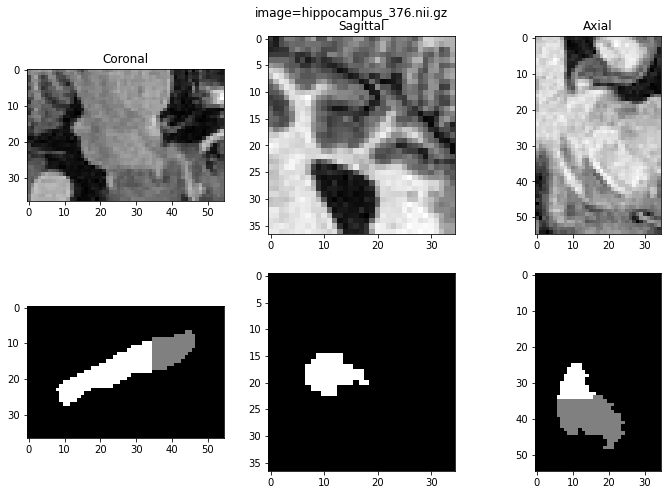

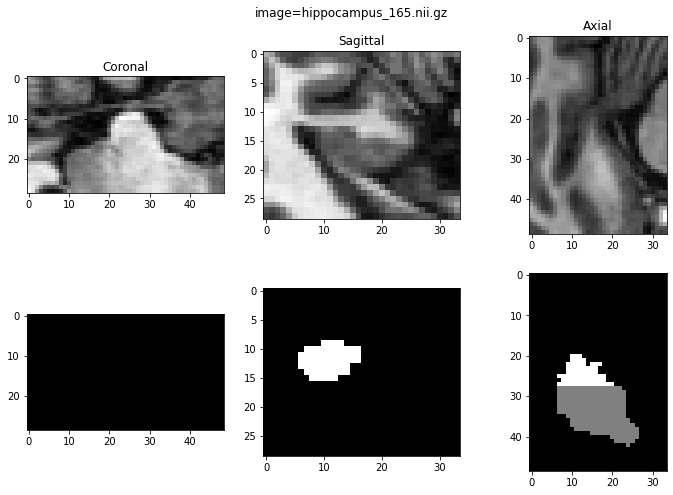

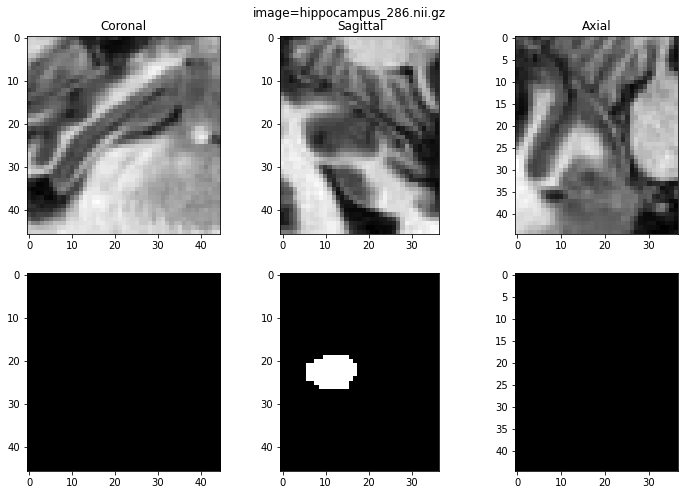

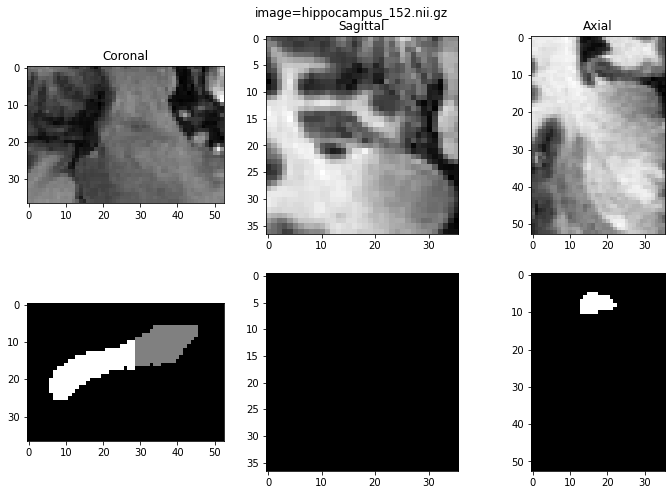

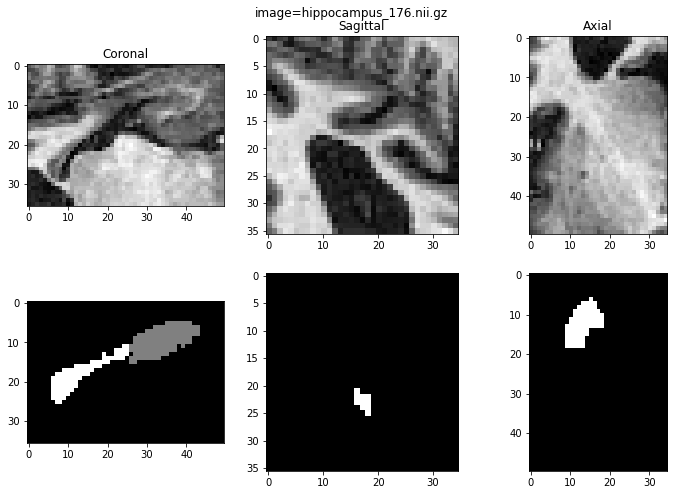

In [14]:
for i in range(5):
    sample_file = dir_train_images[i]
    show_images(sample_file)

Now we can load volume into 3D Slicer to validate that the visualization is correct and get a feel for the shape of structures. While Slicer documentation is not particularly great, there are plenty of YouTube videos available! Just look it up on YouTube if you are not sure how to do something.

![3D slicer](img/Slicer.png)

### Stand out suggestion: Use one of the simple Volume Rendering algorithms that we've implemented in one of our earlier lessons to visualize some of these volumes.

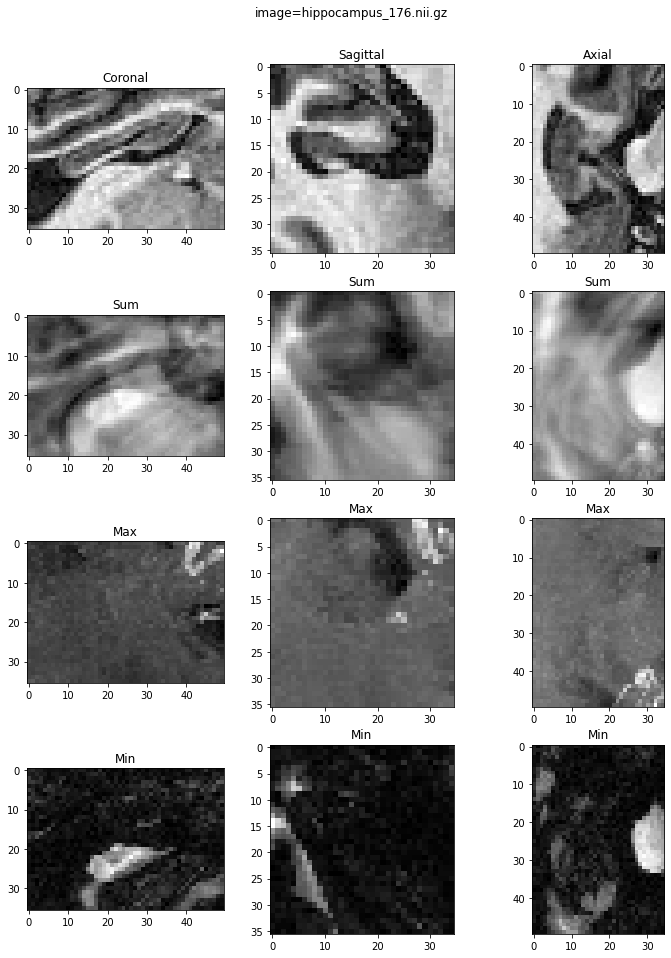

In [15]:
show_volume_rendering(sample_file)

## Looking at single image data
In this section we will look closer at the NIFTI representation of our volumes. In order to measure the physical volume of hippocampi, we need to understand the relationship between the sizes of our voxels and the physical world.

In [16]:
# confirm format of our images
print(image.header_class)
print(label.header_class)

<class 'nibabel.nifti1.Nifti1Header'>
<class 'nibabel.nifti1.Nifti1Header'>


Further down we will be inspecting `.header` attribute that provides access to NIFTI metadata. You can use [this resource](https://brainder.org/2012/09/23/the-nifti-file-format/) as a reference for various fields.

In [17]:
print(image.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 35 51 35  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 1.0
qoffset_y       : 1.0
qoffset_z       : 1.0
srow_x          : [1. 0. 0. 1.]
srow_y          : [0. 

In [18]:
print(label.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 35 51 35  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 1.0
qoffset_y       : 1.0
qoffset_z       : 1.0
srow_x          : [1. 0. 0. 1.]
srow_y          : [0. 

### How many bits per pixel are used?

In [19]:
image.header['bitpix'].item()

8

In [20]:
bit_count = Counter()
for img in images:
    bit_count[images[img].header['bitpix'].item()] += 1
    
print(f'Bits\tCount')
for k, v in bit_count.items():
    print(f'{k}\t{v}')

Bits	Count
32	207
8	55


There are 207 of 32-bit and 55 of 8-bit images.

### What are the units of measurement?

In [21]:
np.unique([images[img].header['xyzt_units'].item() for img in images])

array([10])

In [22]:
spatial_unit, temporal_unit = image.header.get_xyzt_units()

In [23]:
spatial_unit

'mm'

In [24]:
temporal_unit

'sec'

### Do we have a regular grid? What are grid spacings?

Information from [here](https://ibsi.readthedocs.io/en/latest/02_Image_processing.html): "In the context of this work an image is defined as a three-dimensional (3D) stack of two-dimensional (2D) digital image slices. Image slices are stacked along the 𝑧-axis. This stack is furthermore assumed to possess the same coordinate system, i.e. image slices are not rotated or translated (in the 𝑥𝑦-plane) with regards to each other. Moreover, digital images typically possess a finite resolution. Intensities in an image are thus located at regular intervals, or spacing. In 2D such regular positions are called pixels, whereas in 3D the term voxels is used. Pixels and voxels are thus represented as the intersections on a regularly spaced grid. Alternatively, pixels and voxels may be represented as rectangles and rectangular cuboids. The centers of the pixels and voxels then coincide with the intersections of the regularly spaced grid."

**Voxel Dimensions**: The dimension for each voxel is stored in the field `pixdim[8]`, and each element match its respective in `dim[8]`. The value in `pixdim[0]`, however, has a special meaning, discussed below; it should always be -1 or 1. The units of measurement for the first 4 dimensions are specified in the field xyzt_units, discussed below.

**Measurement Units**: Both spatial and temporal measurement units, used for the dimensions `dim[1]` to `dim[4]` (and, respectively, for `pixdim[]`), are encoded in the field `xyzt_units`. The bits 1-3 are used to store the spatial dimensions, the bits 4-6 are for temporal dimensions, and the bits 6 and 7 are not used.

In [25]:
image.header['pixdim']

array([1., 1., 1., 1., 1., 0., 0., 0.], dtype=float32)

`pixdim[0]` should always be -1 or 1. `pixdim[1]` to `pixdim[4]` represent the spacial dimension. To find whether we have irregular spacing, we will check whether some don't adhere to 1.

In [26]:
for im in images:
    if images[im].header['pixdim'][1] != 1:
        print('Found irregular spacing for image', im)
        print(images[im].header['pixdim'])
        remove.append(im)
    if labels[im].header['pixdim'][1] != 1:
        print('Found irregular spacing for label', im)
        print(images[im].header['pixdim'])
        remove.append(im)

Found irregular spacing for image hippocampus_281.nii.gz
[1.       0.785156 0.785156 7.5      0.       0.       0.       0.      ]
Found irregular spacing for label hippocampus_281.nii.gz
[1.       0.785156 0.785156 7.5      0.       0.       0.       0.      ]
Found irregular spacing for image hippocampus_010.nii.gz
[-1.        0.597656  0.597656  1.25      0.        0.        0.
  0.      ]


In [27]:
images, labels, = remove_from_list(remove, images, labels)

to-remove: ['hippocampus_118.nii.gz', 'hippocampus_010.nii.gz', 'hippocampus_281.nii.gz']
images: 260, labels: 260


### What dimensions represent axial, sagittal, and coronal slices? How do you know?

NIFTI uses a left-handed coordinate system for X, Y and Z axes.

* X Coronal
* Y Sagittal
* Z Axial

See [Voxel Terminology and Orientation](http://www.grahamwideman.com/gw/brain/orientation/orientterms.htm).

In [28]:
image.shape

(35, 51, 35)

In [29]:
image.header["dim"][1:4]

array([35, 51, 35], dtype=int16)

### Compute the volume (in mm³) of a hippocampus using one of the labels you've loaded.

You should get a number between ~2200 and ~4500.

In [30]:
print(f'Volume: {np.count_nonzero(label_data)} mm^3')

Volume: 2948 mm^3


## Plotting some charts

Plot a histogram of all volumes that we have in our dataset and see how our dataset measures against a slice of a normal population represented by the chart below.

<img src="img/nomogram_fem_right.svg" width=400 align=left>

In [31]:
all_volumes = np.array([np.count_nonzero(labels[file].get_fdata()) for file in labels])

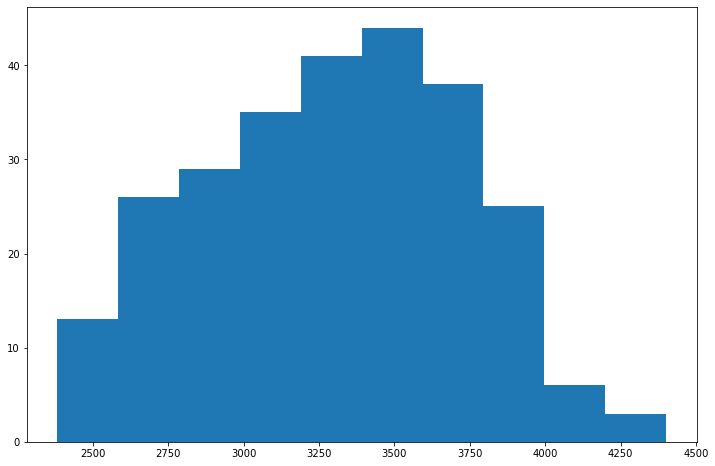

In [32]:
plt.hist(all_volumes, bins=10)
plt.show()

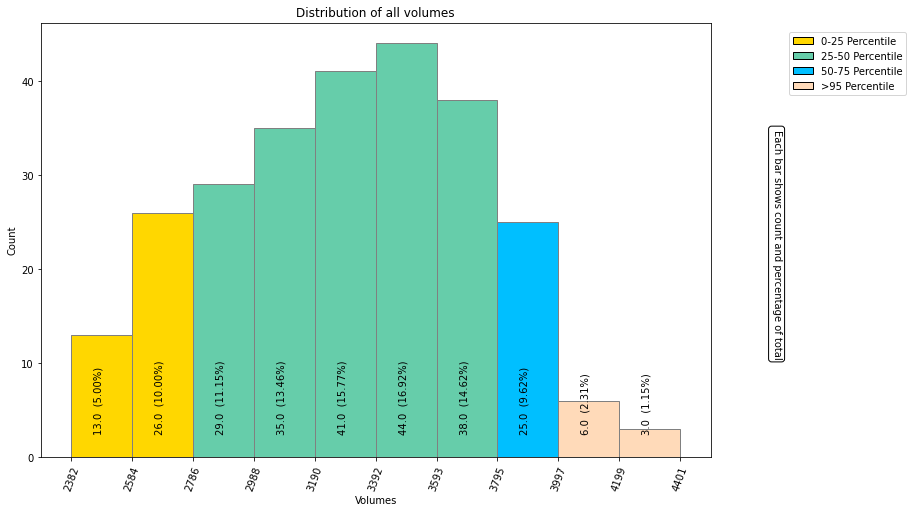

In [33]:
plot_volume_percentiles(all_volumes)

In the real world we would have precise information about the ages and conditions of our patients, and understanding how our dataset measures against population norm would be the integral part of clinical validation. Unfortunately, we do not have this information about this dataset, so we can only guess why it measures the way it is. If you would like to explore further, you can use the [calculator from HippoFit project](http://www.smanohar.com/biobank/calculator.html) to see how our dataset compares against different population slices

Did you notice anything odd about the label files? We hope you did! The mask seems to have two classes, labeled with values `1` and `2` respectively. If you visualized sagittal or axial views, you might have gotten a good guess of what those are. Class 1 is the anterior segment of the hippocampus and class 2 is the posterior one. 

For the purpose of volume calculation we do not care about the distinction, however we will still train our network to differentiate between these two classes and the background

## Copy the clean dataset to the output folder inside section1/out. You will use it in the next Section.

In [34]:
len(images), len(labels)

(260, 260)

In [35]:
! cp -r /data/TestVolumes out/data/
! ls out

README.md  data


In [36]:
import shutil

In [37]:
dir_images_out = 'out/data/TrainingSet/images'
dir_labels_out = 'out/data/TrainingSet/labels'

In [38]:
if os.path.exists(dir_images_out) and os.path.isdir(dir_labels_out):
    shutil.rmtree(dir_images_out)
    
if os.path.exists(dir_labels_out) and os.path.isdir(dir_labels_out):
    shutil.rmtree(dir_labels_out)

In [39]:
if not os.path.exists(dir_images_out):
    os.makedirs(dir_images_out)
    print("Directory " , dir_images_out ,  " created ")
else:    
    print("Directory " , dir_images_out ,  " already exists")

for f in images:
    shutil.copy("/data/TrainingSet/images/" + f, dir_images_out)

Directory  out/data/TrainingSet/images  created 


In [40]:
! ls out/data/TrainingSet/images

hippocampus_001.nii.gz	hippocampus_146.nii.gz	hippocampus_276.nii.gz
hippocampus_003.nii.gz	hippocampus_148.nii.gz	hippocampus_277.nii.gz
hippocampus_004.nii.gz	hippocampus_149.nii.gz	hippocampus_279.nii.gz
hippocampus_006.nii.gz	hippocampus_150.nii.gz	hippocampus_280.nii.gz
hippocampus_007.nii.gz	hippocampus_152.nii.gz	hippocampus_282.nii.gz
hippocampus_008.nii.gz	hippocampus_154.nii.gz	hippocampus_286.nii.gz
hippocampus_011.nii.gz	hippocampus_155.nii.gz	hippocampus_287.nii.gz
hippocampus_014.nii.gz	hippocampus_156.nii.gz	hippocampus_288.nii.gz
hippocampus_015.nii.gz	hippocampus_157.nii.gz	hippocampus_289.nii.gz
hippocampus_017.nii.gz	hippocampus_158.nii.gz	hippocampus_290.nii.gz
hippocampus_019.nii.gz	hippocampus_160.nii.gz	hippocampus_292.nii.gz
hippocampus_020.nii.gz	hippocampus_161.nii.gz	hippocampus_294.nii.gz
hippocampus_023.nii.gz	hippocampus_162.nii.gz	hippocampus_295.nii.gz
hippocampus_024.nii.gz	hippocampus_163.nii.gz	hippocampus_296.nii.gz
hippocampus_025.nii.gz	hippocampus

In [41]:
if not os.path.exists(dir_labels_out):
    os.makedirs(dir_labels_out)
    print("Directory " , dir_labels_out ,  " created ")
else:    
    print("Directory " , dir_labels_out ,  " already exists")

for f in labels:
    shutil.copy("/data/TrainingSet/labels/" + f, dir_labels_out)

Directory  out/data/TrainingSet/labels  created 


In [42]:
! ls out/data/TrainingSet/labels

hippocampus_001.nii.gz	hippocampus_146.nii.gz	hippocampus_276.nii.gz
hippocampus_003.nii.gz	hippocampus_148.nii.gz	hippocampus_277.nii.gz
hippocampus_004.nii.gz	hippocampus_149.nii.gz	hippocampus_279.nii.gz
hippocampus_006.nii.gz	hippocampus_150.nii.gz	hippocampus_280.nii.gz
hippocampus_007.nii.gz	hippocampus_152.nii.gz	hippocampus_282.nii.gz
hippocampus_008.nii.gz	hippocampus_154.nii.gz	hippocampus_286.nii.gz
hippocampus_011.nii.gz	hippocampus_155.nii.gz	hippocampus_287.nii.gz
hippocampus_014.nii.gz	hippocampus_156.nii.gz	hippocampus_288.nii.gz
hippocampus_015.nii.gz	hippocampus_157.nii.gz	hippocampus_289.nii.gz
hippocampus_017.nii.gz	hippocampus_158.nii.gz	hippocampus_290.nii.gz
hippocampus_019.nii.gz	hippocampus_160.nii.gz	hippocampus_292.nii.gz
hippocampus_020.nii.gz	hippocampus_161.nii.gz	hippocampus_294.nii.gz
hippocampus_023.nii.gz	hippocampus_162.nii.gz	hippocampus_295.nii.gz
hippocampus_024.nii.gz	hippocampus_163.nii.gz	hippocampus_296.nii.gz
hippocampus_025.nii.gz	hippocampus

In [43]:
images_out = glob("out/data/TrainingSet/images/*.nii.gz")
labels_out = glob("out/data/TrainingSet/labels/*.nii.gz")

print(f'# images: {len(images_out)}\n# labels: {len(labels_out)}')

# images: 260
# labels: 260


## Final remarks

Congratulations! You have finished Section 1. 

In this section you have inspected a dataset of MRI scans and related segmentations, represented as NIFTI files. We have visualized some slices, and understood the layout of the data. We have inspected file headers to understand what how the image dimensions relate to the physical world and we have understood how to measure our volume. We have then inspected dataset for outliers, and have created a clean set that is ready for consumption by our ML algorithm. 

In the next section you will create training and testing pipelines for a UNet-based machine learning model, run and monitor the execution, and will produce test metrics. This will arm you with all you need to use the model in the clinical context and reason about its performance!